In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import style
plt.style.use('seaborn')

### Parte 1.1.1: Lectura de datos ISD de Barajas y boxplot

In [3]:
stationName = 'BARAJAS'

(Para mejorar esto molaría guardar los datos en algún lugar y así no descargarlos cada vez)

In [4]:
def readDataFrame(stationName):
    url = 'https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    #D: de la página sacamos las posiciones en el str en la que está cada tipo de datos (cada columna) y la pasamos:
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    concat_list = []
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        #df = df.append(data)
        concat_list.append(data)
    df=pd.concat(concat_list)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)} #D: Creamos un diccionario con cada nombre de columna y su data type
    data = df.astype(dictType,copy=True) #D: pasamos el dict a Pandas para que haga las conversiones 

    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)

    # Cambio las unidades de la temperatura a ºC
    data['temp']/=10
    data['tempd']/=10

    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyMin = data.groupby(['year','month','day']).min().drop(['hour'],axis=1).reset_index()
    dataDailyMin['time'] = pd.to_datetime(dataDailyMin[['year','month','day']],yearfirst=True)
    dataDailyMin = dataDailyMin.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMean

dayMean = readDataFrame(stationName)

Seleccionada la estacion BARAJAS con código 082210-99999


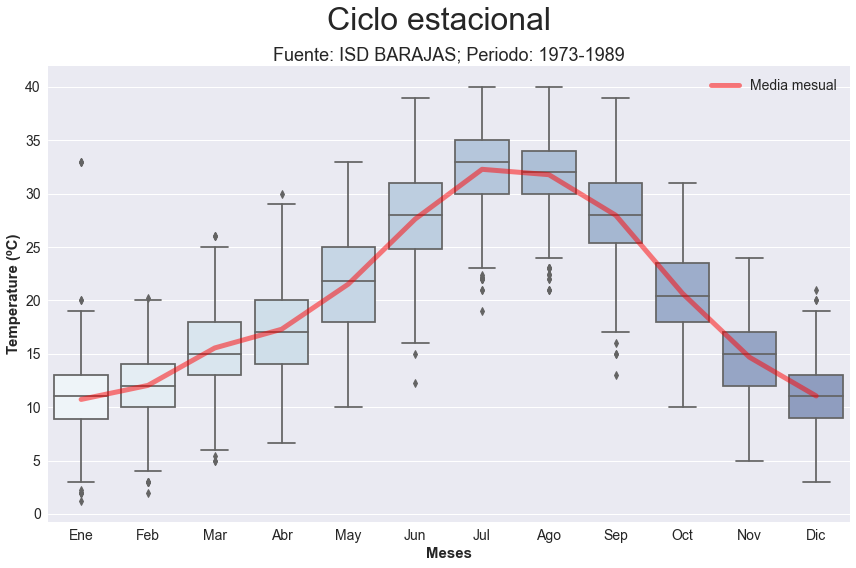

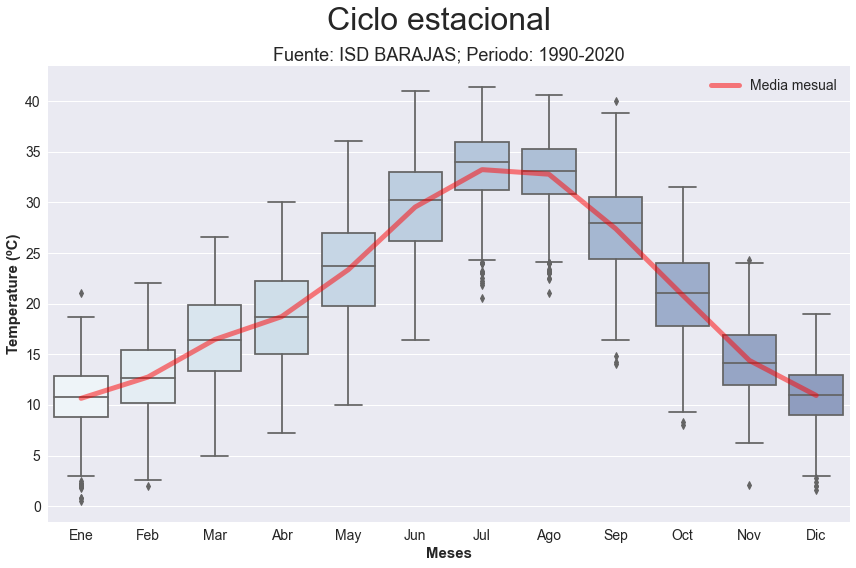

In [5]:
cus = sns.color_palette("ch:start=0.2,rot=-0.2,dark=0.6, light=.95",12) # Paleta de color elegida
def climograma(df,start_year,end_year,save=False,violin = False, outliers = True, figname='barajas',fuente='',palette=cus):
    ''' 
    Función para realizar boxplots del ciclo estacional a partir de unos datos de temperatura a 2m.

    Entradas:
    - df: DataFrame con los datos de temperatura, extructurado por columnas de 'day','month','year','temp'
    - start_year: año de inicio del periodo que queremos representar 
    - end_year: año de fin del periodo que queremos representar 
    - save: si se quiere guardar la figura poner save=1
    - violin: si se quiere represnetar un diagrama de violines poner violin=1
    - outliers: si se quieren quitar los outliers del boxplot poner outliers=0
    - figname: nombre para el png si se pide guardar 'figname'+'.png'
    - fuente: str con el nombre de la fuente de los datos 
    - palette: paleta de colores que se quiere usar

    Salidas:
    - Tupla con la figura (fig) y el axis (ax) donde se representa el plot.
    
    '''
    df = df[(start_year <= df['year'])&(df['year'] <= end_year)]    # Selecciono los años
    means = df.groupby(['month'],dropna=True).mean('temp')          # Media de cada mes para representar encima    
    fig, ax = plt.subplots(figsize=(12,8))
    meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'] # Nombres de los meses para los xtick
    if violin == True: # Si queremos representarlo como violines
        sns.violinplot(data=df, x='month', y='temp', ax=ax, showfliers = False)
    else: 
        if outliers == True: # Boxplot con outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax,zorder=2,palette=palette) #,whis=2)
            
        else: # Boxplot sin outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax, showfliers = False,boxprops=dict(alpha=.7,zorder= 2),zorder=2)


    # Plot de la línea de medias
    ax.plot(np.arange(12), means['temp'],linewidth=5, color ='r',zorder=3, alpha=0.5, label='Media mesual')
    # Ajustes del ax
    ax.set_ylabel('Temperature (ºC)', size=15 , fontweight = 'bold')
    ax.set_xlabel('Meses', size=15, fontweight = 'bold')
    ax.set_xticks(np.arange(12),meses,size=14) # Para cambiar las etiquetas a los nombres de meses
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(prop={'size':14})

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2 # Para alinear el title y el suptitle
    plt.suptitle('Ciclo estacional',size=32, x=mid)
    plt.title(u'Fuente: %s; Periodo: %i-%i'%(fuente,start_year,end_year), size=18)
    plt.tight_layout()
    if save == True:  # Si queremos guardar la figura
        fig.savefig(figname+'.png',dpi=500,facecolor='w')
        
    return fig, ax

fig, ax = climograma(dayMean,1973,1989, fuente='ISD '+stationName)
fig, ax = climograma(dayMean,1990,2020, fuente='ISD '+stationName)

--- 
Lo que hay a partir de aquí no está completo

### Parte 1.1.2
Meses de Enero y Julio (por separado):
- Histograma
- Ajuste a normal
- Percentiles 5% y 95% de los datos y el ajuste
- Intervalo de confianza de la media con un nivel del 95%

++ Cosas que Molaría Hacer II: poner todos los ajustes que le hago a los plots (tamños de cosas, mostrar leyenda, etc) en una función sola y llamarla sin más (o cambiar los rcParam)

-- Algo importante que recordar: estamos tratando con datos horarios, tenemos cada hora de cada día de cada mes (muuchos datos). Also, un diagrama de violines ya da la información que vamos a ver ahora en este histograma...

In [6]:
# Esto mucho mejor modificar los rc.params ...
def configs(fig,ax):
    ax.xaxis.label.set_size(15)
    ax.xaxis.label.set_fontweight('bold')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.label.set_size(15)
    ax.yaxis.label.set_fontweight('bold')
    ax.yaxis.set_tick_params(labelsize=14)
    ax.title.set_size(18)
    plt.tight_layout()

In [7]:
# Seleccionamos el mes (luego esto igual sería mejor meterlo en una función)
mes = 7 # Enero
d_mes = data.loc[data['month']==mes]
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(d_mes['temp'],binwidth=1 ,stat='probability')
configs(fig, ax)


NameError: name 'data' is not defined

--- 

### Parte 1.1.3 Contraste de hiposteis



In [ ]:
from scipy import stats

In [ ]:
d1 =  data[(1973 <= data['year'])&(data['year'] <= 1989)&(data['month']==1)].groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
d2 =  data[(1989 <= data['year'])&(data['year'] <= 2020)&(data['month']==1)].groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
d1


,year,month,day,temp,tempd,slp,windDir,windSpeed,cloud,pcp1h,pcp6h
0,1973,1,1,2.095238,-7.619048,10239.000000,39.565217,4.347826,0.500000,NaN,NaN
1,1973,1,2,1.500000,-9.090909,10290.125000,5.454545,1.363636,0.000000,NaN,0.0
2,1973,1,3,1.260870,-31.304348,10292.125000,83.913043,14.739130,2.250000,NaN,NaN
3,1973,1,4,3.380952,-17.619048,10265.857143,79.090909,5.909091,0.000000,NaN,NaN
4,1973,1,5,1.434783,-19.565217,10260.625000,5.000000,1.250000,0.125000,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...
522,1989,1,27,2.910000,-22.750000,10328.500000,48.000000,3.900000,0.285714,NaN,0.0
523,1989,1,28,2.643478,-20.434783,10356.000000,28.260870,2.652174,1.571429,NaN,0.0
524,1989,1,29,3.095652,-22.478261,10383.571429,62.173913,7.217391,0.625000,NaN,0.0
525,1989,1,30,3.208333,-35.416667,10382.500000,13.750000,0.625000,0.000000,NaN,0.0


In [ ]:
def contraste_media(d1,d2,var='temp',alpha=0.05):
    x1 = d1[var].mean()
    x2 = d2[var].mean()
    s1_2 = d1[var].var()
    s2_2 = d1[var].var()
    n1 = d1[var].size
    print(n1)
    n2 = d2[var].size

    z = x1-x2/((s1_2/n1)+(s2_2/n2))**0.5
    print(z)

    z_alpha_2 = stats.norm.ppf(1-alpha/2)
    print(z_alpha_2)
    if (abs(z)>z_alpha_2):
        print('Rechazo')
        return False
    else:
        print('Acepto')
        return True        

In [ ]:
contraste_media(d1,d2,alpha=0.05)


527
-27.455235929445156
1.959963984540054
Rechazo


False